# SITS-BERT Complete Pipeline Exploration

- Main ideas:
    1. Explore data structure;

## Initial Setup

In [1]:
# Reload modules automatically before executing code.
%load_ext autoreload
%autoreload 2

In [2]:
# Add SITS-BERT source code for import.
import sys

path = "/geosatlearn_app/ml_models/sits-bert"
if path not in sys.path:
    sys.path.append(path)
    print(f">>> Added {path} to sys.path")

>>> Added /geosatlearn_app/ml_models/sits-bert to sys.path


In [3]:
# Import modules.
import os
import random

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from torch.utils.data import Subset

from sitsbert.model import SBERT
from sitsbert.trainer import SBERTTrainer
from sitsbert.dataset import FineTuneDataset, PreTrainDataset
from sitsbert.dataset.dataset_wrapper import DataSetWrapper

## Data Structures

In [4]:
# Main parameters.
file_path = "/geosatlearn_app/ml_models/sits-bert/datafiles/california-labeled/Test.csv"
num_features = 10
seq_len = 64
bands_scale_factor = 1.0 / 10000.0
probability_for_masking = 0.15
positive_noise_amplitude = 0.5

### Fine Tunning Dataset

In [5]:
%%time

fine_tune_dataset_test = FineTuneDataset(
    file_path=file_path,
    num_features=num_features,
    seq_len=seq_len,
    bands_scale_factor=bands_scale_factor,
)

CPU times: user 993 ms, sys: 407 ms, total: 1.4 s
Wall time: 1.4 s


In [6]:
# Data set size.
print(f">>> Dataset length: {len(fine_tune_dataset_test)}")

>>> Dataset length: 318588


#### Subset for Fine Tunning Dataset

In [7]:
# First we can reduce the dataset to a fixed size by selecting N random samples:
subset_size = 1000  # Define the size of the subset you want.
random_indices = random.sample(range(len(fine_tune_dataset_test)), subset_size)

# Subset the dataset using the random indices.
fine_tune_dataset_test_reduced = Subset(
    dataset=fine_tune_dataset_test, indices=random_indices
)

# Print the sizes of the original and reduced datasets.
print(f">>> Original: {len(fine_tune_dataset_test)} data instances ...")
print(f">>> Reduced: {len(fine_tune_dataset_test_reduced)} data instances ...")

>>> Original: 318588 data instances ...
>>> Reduced: 1000 data instances ...


In [8]:
# Random selection.
intidx = np.random.randint(0, len(fine_tune_dataset_test_reduced))
print(f">>> Random index: {intidx}")

>>> Random index: 684


In [9]:
# Dataset instance.
data_instance = fine_tune_dataset_test[intidx]
data_instance.keys()

dict_keys(['bert_input', 'bert_mask', 'class_label', 'time'])

In [10]:
data_instance["bert_input"].shape

torch.Size([64, 10])

In [11]:
data_instance["bert_mask"]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
data_instance["class_label"]

tensor([7])

In [13]:
data_instance["time"]

tensor([  2,  77,  97, 102, 107, 112, 127, 132, 152, 157, 172, 177, 182, 187,
        192, 197, 202, 207, 212, 222, 227, 232, 237, 242, 247, 252, 257, 262,
        267, 272, 282, 287, 297, 302, 307, 322, 327,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])

### Plot Time Series

In [14]:
# Extract tensors.
mask = data_instance["bert_mask"].bool()
bands = data_instance["bert_input"][mask]
doys = data_instance["time"][mask]
label = data_instance["class_label"]

# Sentinel 2 bands names.
bands_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

# Save data in a pandas DataFrame.
df_bands = pd.DataFrame(data=bands.numpy(), index=doys.numpy(), columns=bands_names)

# Show it.
df_bands

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
2,0.0437,0.0594,0.0688,0.1092,0.1347,0.1542,0.1736,0.1840,0.1841,0.1264
77,0.0766,0.1036,0.1206,0.1709,0.2248,0.2464,0.2686,0.2717,0.2058,0.1335
97,0.0305,0.0577,0.0435,0.0985,0.2599,0.3005,0.3140,0.3189,0.1836,0.1036
102,0.0418,0.0660,0.0525,0.1008,0.2624,0.3075,0.3284,0.3278,0.1919,0.1131
107,0.0327,0.0583,0.0430,0.0939,0.2716,0.3146,0.3322,0.3328,0.1798,0.0998
112,0.0395,0.0595,0.0481,0.0931,0.2644,0.3193,0.3352,0.3366,0.1850,0.1065
127,0.0386,0.0662,0.0559,0.1086,0.2908,0.3425,0.3562,0.3601,0.1952,0.1103
132,0.0454,0.0680,0.0511,0.1019,0.2843,0.3447,0.3564,0.3593,0.1983,0.1118
152,0.0503,0.0722,0.0573,0.1020,0.2662,0.3202,0.3274,0.3356,0.1904,0.1100
157,0.0345,0.0680,0.0507,0.1062,0.2829,0.3310,0.3422,0.3468,0.1935,0.1102


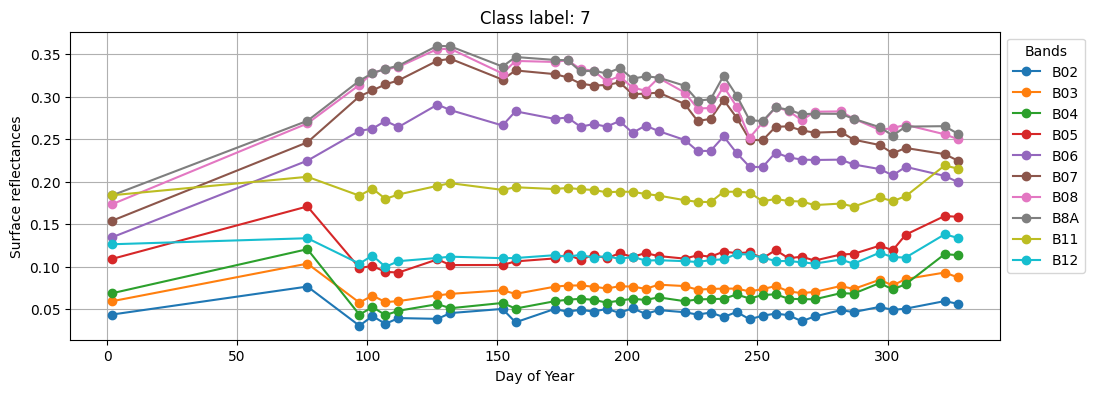

In [15]:
# Plot bands.
df_bands.plot(
    figsize=(12, 4),
    title=f"Class label: {label.numpy()[0]}",
    xlabel="Day of Year",
    ylabel="Surface reflectances",
    grid=True,
    marker="o",
)

# Legend outside the plot.
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Bands", fontsize=10);

## Pre Training Experiment

### Dataloader

In [16]:
# Main parameters.
file_path = (
    "/geosatlearn_app/ml_models/sits-bert/datafiles/california-excluded-labels/Test.csv"
)
num_features = 10
seq_len = 64
bands_scale_factor = 1.0 / 10000.0
probability_for_masking = 0.15
positive_noise_amplitude = 0.5

In [17]:
# Prepare pre-training dataset.
pretrain_data_set = PreTrainDataset(
    file_path=file_path,
    num_features=num_features,
    seq_len=seq_len,
    bands_scale_factor=bands_scale_factor,
    probability_for_masking=probability_for_masking,
    positive_noise_amplitude=positive_noise_amplitude,
)

>>> Loading data successful ...


#### Subset for Pretraining Dataset

In [18]:
# First we can reduce the dataset to a fixed size by selecting N random samples:
subset_size = 1000  # Define the size of the subset you want.
random_indices = random.sample(range(len(pretrain_data_set)), subset_size)

# Subset the dataset using the random indices.
pretrain_data_set_reduced = Subset(dataset=pretrain_data_set, indices=random_indices)

# Print the sizes of the original and reduced datasets.
print(f">>> Original: {len(pretrain_data_set)} data instances ...")
print(f">>> Reduced: {len(pretrain_data_set_reduced)} data instances ...")

>>> Original: 318588 data instances ...
>>> Reduced: 1000 data instances ...


### Visualize Instance

In [19]:
# Select a random sample from the pre-training dataset.
intidx = np.random.randint(0, len(pretrain_data_set_reduced))
data_instance = pretrain_data_set_reduced[intidx]

print(f">>> Random index: {intidx}")

>>> Random index: 559


In [20]:
# Extract tensors.
bert_mask = data_instance["bert_mask"].bool()
bands = data_instance["bert_target"][bert_mask]
bands_perturbed = data_instance["bert_input"][bert_mask]
loss_mask = data_instance["loss_mask"][bert_mask]
doys = data_instance["time"][bert_mask]

# Print number of valid timesteps.
valid_timesteps = bert_mask.sum().item()
print(f">>> Number of valid timesteps: {valid_timesteps}")

# Verify if the timesteps are more than seq length.
if valid_timesteps > seq_len:
    print(
        f">>> Warning: Number of valid timesteps ({valid_timesteps}) is less than seq length ({seq_len})!"
    )

>>> Number of valid timesteps: 44


In [21]:
# Save data in a pandas DataFrame.
df_bands = pd.DataFrame(data=bands.numpy(), index=doys.numpy(), columns=bands_names)

# Save data in a pandas DataFrame.
df_bands_perturbed = pd.DataFrame(
    data=bands_perturbed.numpy(), index=doys.numpy(), columns=bands_names
)

# Create columns for locations of perturbed pixels.
df_bands["perturbed"] = loss_mask.numpy()
df_bands_perturbed["perturbed"] = loss_mask.numpy()

# Count number of perturbed pixels.
num_perturbed = np.sum(loss_mask.numpy())

# Show it.
df_bands_perturbed

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,perturbed
2,0.063900,0.088000,0.100700,0.137000,0.161200,0.172000,0.190800,0.196000,0.256600,0.211200,0
37,0.067200,0.094800,0.107800,0.139800,0.171900,0.185400,0.212600,0.203000,0.219800,0.173000,0
42,0.073200,0.095500,0.107600,0.144600,0.183200,0.195700,0.224600,0.213100,0.220800,0.169900,0
72,0.143600,0.190600,0.219000,0.266800,0.288300,0.302300,0.328600,0.318600,0.385800,0.354600,0
77,0.157800,0.213600,0.249800,0.286400,0.309900,0.326900,0.344800,0.339900,0.399000,0.348500,0
87,0.161000,0.216600,0.245800,0.302700,0.333700,0.350700,0.379400,0.365700,0.414200,0.356000,0
97,0.128600,0.184800,0.203200,0.259700,0.310200,0.324900,0.334800,0.340300,0.368500,0.308100,0
102,0.107800,0.154800,0.159800,0.230200,0.309700,0.336400,0.354000,0.353100,0.329900,0.265500,0
107,0.117200,0.159200,0.177400,0.225600,0.339300,0.365900,0.379200,0.381200,0.311500,0.228600,0
112,0.099300,0.141000,0.149000,0.209200,0.331100,0.366200,0.388200,0.381800,0.298200,0.227600,0


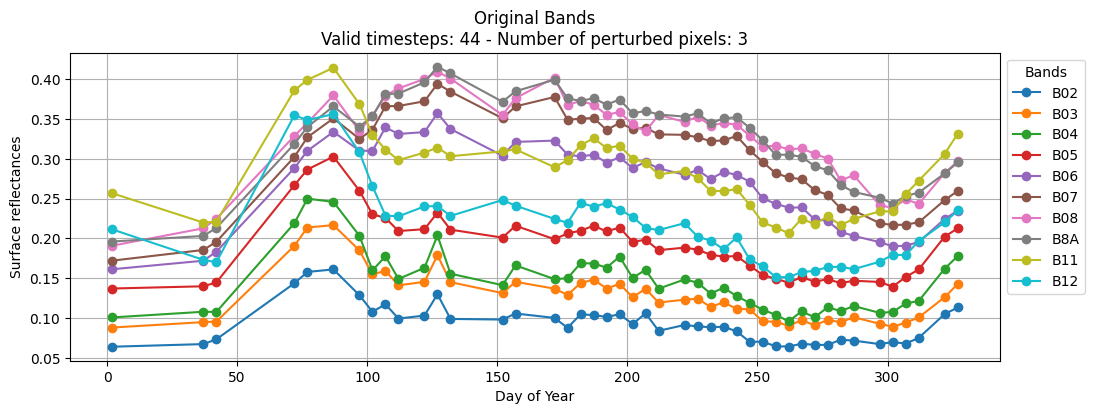

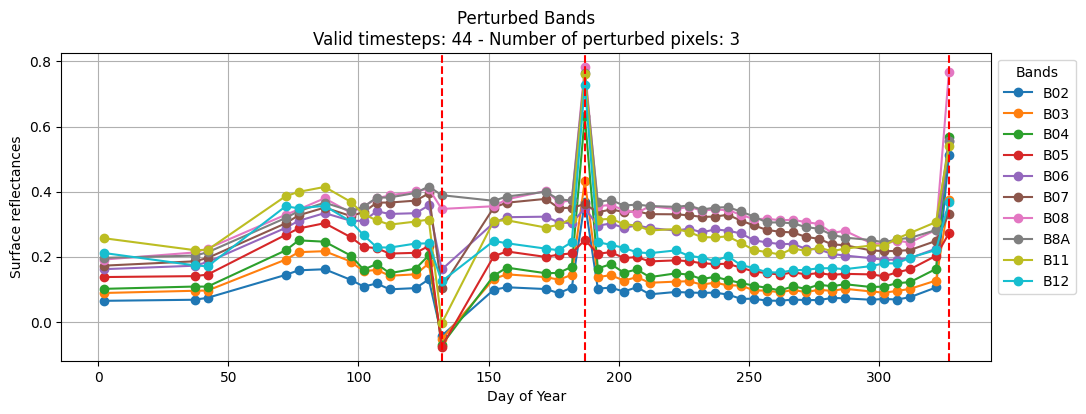

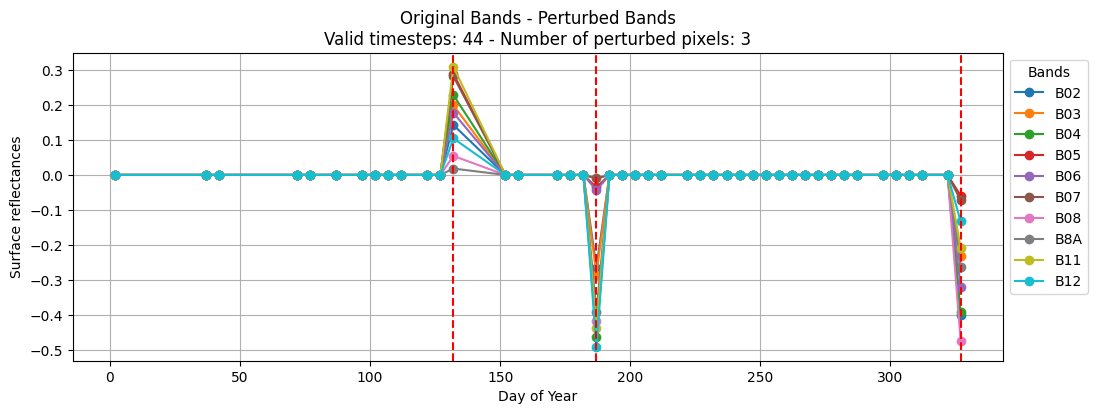

In [22]:
# Plot original time series
ax1 = df_bands.drop(labels=["perturbed"], axis=1).plot(
    figsize=(12, 4),
    title=f"Original Bands\nValid timesteps: {valid_timesteps} - Number of perturbed pixels: {num_perturbed}",
    xlabel="Day of Year",
    ylabel="Surface reflectances",
    grid=True,
    marker="o",
)

# Plot perturbed time series.
ax2 = df_bands_perturbed.drop(labels=["perturbed"], axis=1).plot(
    figsize=(12, 4),
    title=f"Perturbed Bands\nValid timesteps: {valid_timesteps} - Number of perturbed pixels: {num_perturbed}",
    xlabel="Day of Year",
    ylabel="Surface reflectances",
    grid=True,
    marker="o",
)

# Plot different y-axis for perturbed time series.
ax3 = (
    df_bands.drop(labels=["perturbed"], axis=1)
    - df_bands_perturbed.drop(labels=["perturbed"], axis=1)
).plot(
    figsize=(12, 4),
    title=f"Original Bands - Perturbed Bands\nValid timesteps: {valid_timesteps} - Number of perturbed pixels: {num_perturbed}",
    xlabel="Day of Year",
    ylabel="Surface reflectances",
    grid=True,
    marker="o",
)

# Plot perturbed locations as vertical red lines.
for idx in df_bands_perturbed.index:
    if df_bands_perturbed.loc[idx, "perturbed"]:
        doy = df_bands_perturbed.loc[idx].name
        ax2.axvline(x=doy, color="red", linestyle="--", linewidth=1.5)
        ax3.axvline(x=doy, color="red", linestyle="--", linewidth=1.5)

# Legend outside the plot.
ax1.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Bands",
    fontsize=10,
)

# Legend outside the plot.
ax2.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Bands",
    fontsize=10,
)

# Legend outside the plot.
ax3.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Bands",
    fontsize=10,
);

### Experiment Configuration

In [23]:
# Experiment name.
experiment = "alex-initial-test"

# The input pre training data path.
dataset_path = (
    "/geosatlearn_app/ml_models/sits-bert/datafiles/california-excluded-labels/Test.csv"
)

# The output directory where the pre-training checkpoints will be written.
pretrain_path = (
    f"/geosatlearn_app/ml_models/sits-bert/checkpoints/pretrain-{experiment}/"
)


# Proportion of training data to use for validation in pre-training stage.
valid_rate = 0.03


max_length = 64
num_features = 10

# Number of epochs for pre-training.
epochs = 2

batch_size = 512

# Hidden size of the SITS-BERT model.
hidden_size = 256

# Number of Transformer blocks (layers).
layers = 3

# Number of attention heads in each transformer block.
attn_heads = 8
learning_rate = 1e-4
warmup_epochs = 1
decay_gamma = 0.99
dropout = 0.1
gradient_clipping = 5.0

In [24]:
# Create output folder for pre-training checkpoints if it does not exist.
if not os.path.exists(pretrain_path):
    os.makedirs(pretrain_path)
    print(f">>> Created output folder: {pretrain_path}")

In [25]:
# Interface for creating PyTorch DataLoaders for training and validation datasets.
dataset = DataSetWrapper(
    batch_size=batch_size,
    valid_size=valid_rate,
    data_path=dataset_path,
    num_features=num_features,
    max_length=max_length,
    subset_fraction=0.1,
)

# Get the training and validation DataLoaders.
train_loader, valid_loader = dataset.get_data_loaders()

>>> Loading data successful ...
>>> Samples; Total: 31858; Training: 30903; Validation: 955


In [26]:
# Check if the training and validation sets have any common indices.
common_indices = set(train_loader.sampler.indices).intersection(
    set(valid_loader.sampler.indices)
)
print(f">>> Common indices in training and validation sets: {len(common_indices)}")

>>> Common indices in training and validation sets: 0


In [27]:
sbert = SBERT(
    num_features=num_features,
    hidden=hidden_size,
    n_layers=layers,
    attn_heads=attn_heads,
    dropout=dropout,
)

In [28]:
trainer = SBERTTrainer(
    sbert=sbert,
    num_features=num_features,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    lr=learning_rate,
    warmup_epochs=warmup_epochs,
    decay_gamma=decay_gamma,
    gradient_clipping_value=gradient_clipping,
)

Total Parameters: 2373258


In [29]:
mini_loss = np.inf
for epoch in range(epochs):
    train_loss, valida_loss = trainer.train(epoch)
    if mini_loss > valida_loss:
        mini_loss = valida_loss
        trainer.save(epoch, pretrain_path)

EP_train:0:   0%|| 0/60 [00:00<?, ?it/s]

/geosatlearn_app/ml_models/sits-bert/sitsbert/trainer/pretrain.py:80: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  nn.utils.clip_grad_norm(self.model.parameters(), self.gradient_clippling)
EP_train:0:   2%|| 1/60 [00:09<08:56,  9.09s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 2.9397284984588623, 'loss': 2.9397284984588623}


EP_train:0:  18%|| 11/60 [01:18<05:42,  7.00s/it]

{'epoch': 0, 'iter': 10, 'avg_loss': 1.4051978588104248, 'loss': 0.8783454895019531}


EP_train:0:  35%|| 21/60 [02:35<04:48,  7.40s/it]

{'epoch': 0, 'iter': 20, 'avg_loss': 1.038876547699883, 'loss': 0.512847900390625}


EP_train:0:  52%|| 31/60 [03:44<03:01,  6.27s/it]

{'epoch': 0, 'iter': 30, 'avg_loss': 0.8421806337371949, 'loss': 0.37078946828842163}


EP_train:0:  68%|| 41/60 [05:02<02:20,  7.38s/it]

{'epoch': 0, 'iter': 40, 'avg_loss': 0.7160269501732617, 'loss': 0.2928020656108856}


EP_train:0:  85%|| 51/60 [06:15<01:13,  8.13s/it]

{'epoch': 0, 'iter': 50, 'avg_loss': 0.6281646370303398, 'loss': 0.2458779364824295}


EP_train:0: 100%|| 60/60 [07:23<00:00,  7.39s/it]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:813: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


EP0, train_loss=0.56892, validate_loss=0.04515
EP:0 Model Saved on: /geosatlearn_app/ml_models/sits-bert/checkpoints/pretrain-alex-initial-test/checkpoint.tar


EP_train:1:   2%|| 1/60 [00:09<08:51,  9.01s/it]

{'epoch': 1, 'iter': 0, 'avg_loss': 0.2190435230731964, 'loss': 0.2190435230731964}


EP_train:1:  18%|| 11/60 [01:34<07:06,  8.71s/it]

{'epoch': 1, 'iter': 10, 'avg_loss': 0.20616996152834458, 'loss': 0.19707289338111877}


EP_train:1:  35%|| 21/60 [02:54<04:44,  7.28s/it]

{'epoch': 1, 'iter': 20, 'avg_loss': 0.19726037127631052, 'loss': 0.18151262402534485}


EP_train:1:  52%|| 31/60 [04:17<04:14,  8.79s/it]

{'epoch': 1, 'iter': 30, 'avg_loss': 0.18908725150169864, 'loss': 0.1640143245458603}


EP_train:1:  68%|| 41/60 [05:28<02:10,  6.85s/it]

{'epoch': 1, 'iter': 40, 'avg_loss': 0.18226088983256641, 'loss': 0.15637364983558655}


EP_train:1:  85%|| 51/60 [06:41<01:04,  7.18s/it]

{'epoch': 1, 'iter': 50, 'avg_loss': 0.17590362943854987, 'loss': 0.1464909017086029}


EP_train:1: 100%|| 60/60 [07:49<00:00,  7.82s/it]


EP1, train_loss=0.17087, validate_loss=0.04350
EP:1 Model Saved on: /geosatlearn_app/ml_models/sits-bert/checkpoints/pretrain-alex-initial-test/checkpoint.tar
